# Using the ml4qc package for a specific example analysis ("CATI1")

This workbook demonstrates an example analysis for a particular CATI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CATI1".

In [1]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

## Loading data from SurveyCTO export

Here, we load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **duration** - Total number of seconds spent editing form
* **instance_time** - Timestamp in an unusual format; will be dropped
* **TA** - Relative path to text audit `.csv` file
* **pct_conversation** - Percent of form-editing time when conversation was detected ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **KEY** - Unique submission ID

In [2]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones (b/c storage and text audit formats don't automatically include timezone info)
data_tz = pytz.timezone("Asia/Kabul").zone
collection_tz = pytz.timezone("Asia/Kabul").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("~/ml4qc-data/collab1/cati1/cati1.csv"), attachments_available=True)

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print()

# load all text audits into DataFrame and describe contents
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.TA)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

    all_data = submissions_df

Submission DataFrame field counts:
SubmissionDate      6032
starttime           6032
endtime             6031
duration            6032
instance_time       6032
TA                  6032
pct_conversation    6031
review_status       6032
review_quality      6032
dtype: int64

Submission DataFrame review status and quality:
APPROVED    5800
REJECTED     232
Name: review_status, dtype: Int64
OKAY    2992
GOOD    2761
POOR     279
Name: review_quality, dtype: Int64

Text audit DataFrame field counts:
field         1244960
duration_s    1244960
visited_s     1244960
dtype: int64

Combined DataFrame field counts:
SubmissionDate                                                                              6032
starttime                                                                                   6032
endtime                                                                                     6031
duration                                                                                    6032

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict, and we preprocess the data to prepare for analysis.

In [3]:
from ml4qc import SurveyMLClassifier

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.9

# make a copy of the data for analysis, so that we can transform it at will, dropping columns we don't need and rows with missing values
analysis_df = all_data.drop(["instance_time", "SubmissionDate", "starttime", "endtime", "duration", "TA"], axis=1).copy(deep=True)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]

# organize DataFrames with features and classes for prediction
classes_df = analysis_df.loc[:, ["review_status", "review_quality"]]
features_df = analysis_df.drop(["review_status", "review_quality"], axis=1)

# set our target for prediction
# target_description = "APPROVED submissions classified as GOOD quality"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 0), axis=1)
target_description = "REJECTED submissions"
classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "REJECTED" else 0), axis=1)
# target_description = "POOR submissions"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_quality"] == "POOR" else 0), axis=1)
target_df = pd.DataFrame(classes_df["target"])

# create SurveyML object with 75% test vs. train size
surveyml = SurveyMLClassifier(features_df, target_df, test_size=0.25, cv_when_training=True, random_state=None, verbose=True, reweight_classes=True)

# preprocess data
surveyml.preprocess_for_prediction(pca=pca)

numeric features: 6276
numeric_binary features: 2185
numeric_unit_interval features: 4085
numeric_other features: 6
datetime features: 0
other features: 2
  Starting training set shape: (4522, 6278)
Starting prediction set shape: (1508, 6278)
     Final training set shape: (4522, 393)
   Final prediction set shape: (1508, 393)


## Performing analysis

In the cells that follow, we perform a series of analyses using the scikit-learn and Tensorflow Keras libraries, making use of the utilities available in the SurveyMLClassifier class.

In [4]:
%%time

model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

x_outlier_df = surveyml.identify_outliers()

x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

Outliers: 135 (2.2388059701492535%)
CPU times: user 1min 3s, sys: 6.88 s, total: 1min 9s
Wall time: 1min 9s


target,0,1
is_outlier,,
False,0.977578,0.978448
True,0.022422,0.021552


  Predicting: REJECTED submissions
       Model: Logistic regression

Running prediction model...

  Training set: (4522, 393) (170 positive)
Prediction set: (1508, 393)

Cross-validating model...

      Train accuracy:  91.15%
     Train precision:  29.46%
           Train F-1:  0.45
 Prediction accuracy:  89.46%
Prediction precision:  16.08%
      Prediction F-1:  0.22
  Test ROC_AUC Score:  0.64

Cross validation results: 

fit_time: 0.26013836860656736 (SD: 0.04593011050835992)
score_time: 0.005713129043579101 (SD: 0.0010166947136359295)
test_accuracy: 0.8827220945582556 (SD: 0.00851526884900709)
test_precision: 0.15591861830171536 (SD: 0.02458742838939952)
test_f1: 0.23512557189314282 (SD: 0.03694857889601107)
test_roc_auc: 0.747093204596459 (SD: 0.04545843814039959)


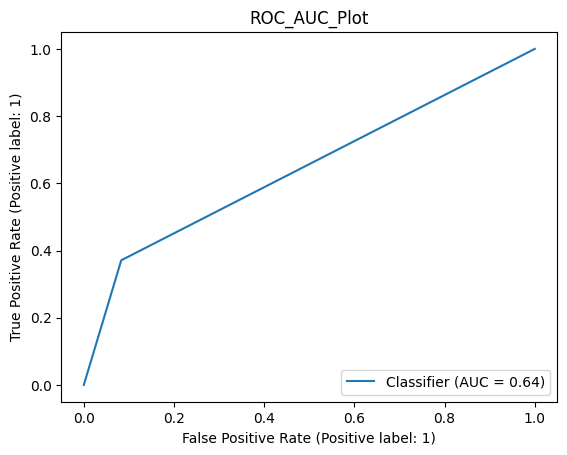

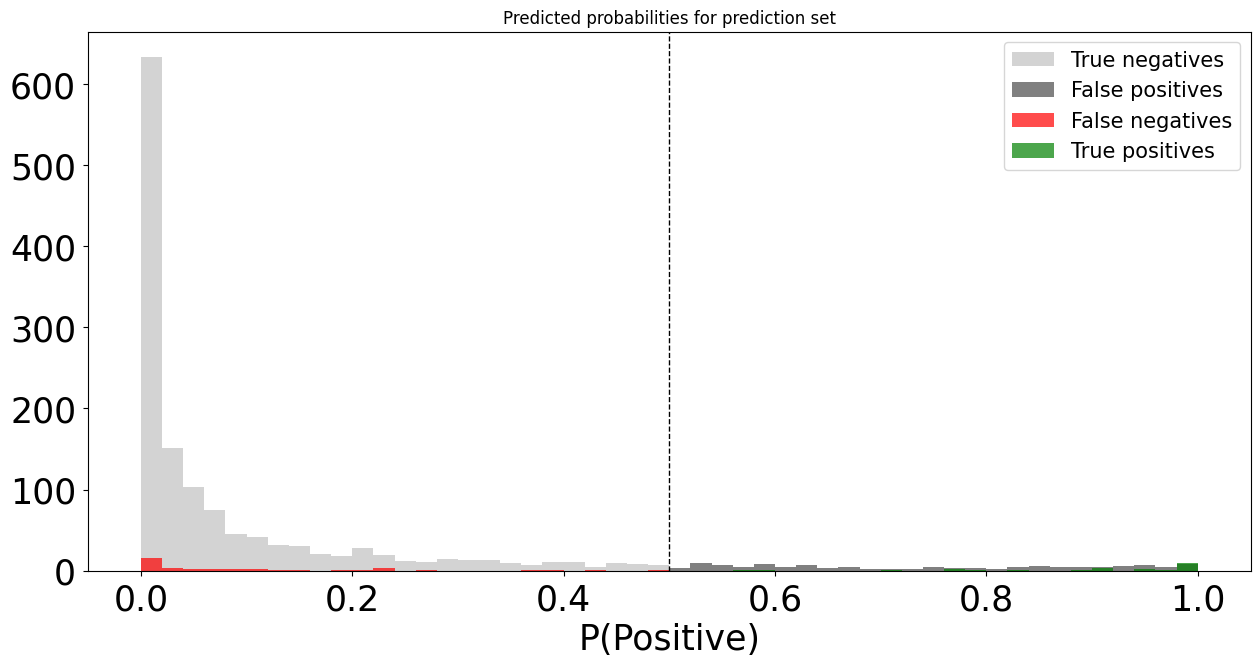

Test P(1) =  4.11%
Test P(1 | predicted 1) =  16.08%
Test P(1 | predicted 0) =  2.86%

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1446
           1       0.16      0.37      0.22        62

    accuracy                           0.89      1508
   macro avg       0.57      0.64      0.58      1508
weighted avg       0.94      0.89      0.91      1508



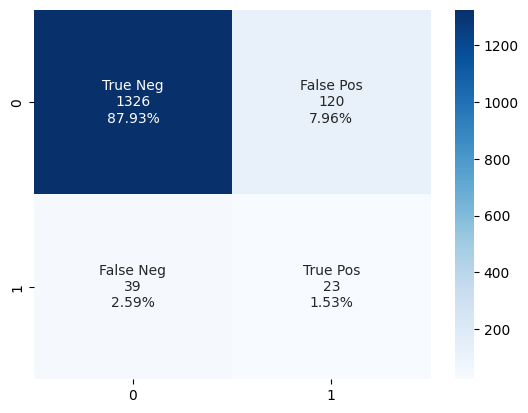

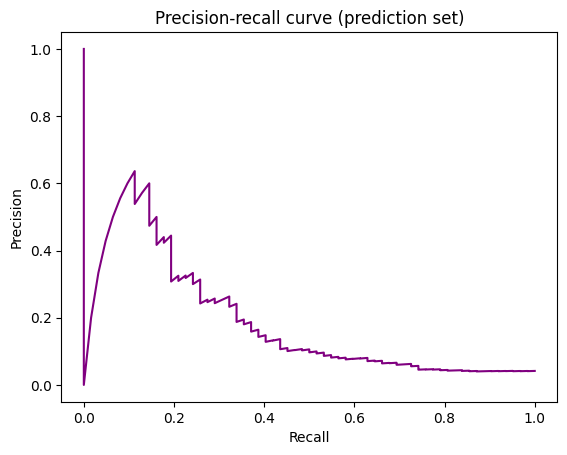

Predictions made: 1508
CPU times: user 24.4 s, sys: 3.59 s, total: 28 s
Wall time: 5.55 s


In [27]:
%%time

model_description = "Logistic regression"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print()

from sklearn.linear_model import LogisticRegression

classifier_lr = LogisticRegression(random_state=None, C=0.01, penalty='l2', max_iter=10000, class_weight=surveyml.class_weights)
predictions = surveyml.run_prediction_model(classifier_lr)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_lr.coef_[0])

  Predicting: REJECTED submissions
       Model: Decision tree

Running prediction model...

  Training set: (4522, 393) (170 positive)
Prediction set: (1508, 393)

Cross-validating model...

      Train accuracy:  95.13%
     Train precision:  43.59%
           Train F-1:  0.61
 Prediction accuracy:  89.59%
Prediction precision:  13.74%
      Prediction F-1:  0.19
  Test ROC_AUC Score:  0.61

Cross validation results: 

fit_time: 0.941743262608846 (SD: 0.19134133913157572)
score_time: 0.005311203002929687 (SD: 0.0007831405064378626)
test_accuracy: 0.8909822519923729 (SD: 0.01552339465695179)
test_precision: 0.10975086307756764 (SD: 0.031051524863024312)
test_f1: 0.1536406680649133 (SD: 0.0406966951641424)
test_roc_auc: 0.5893620755638254 (SD: 0.03698066787970859)


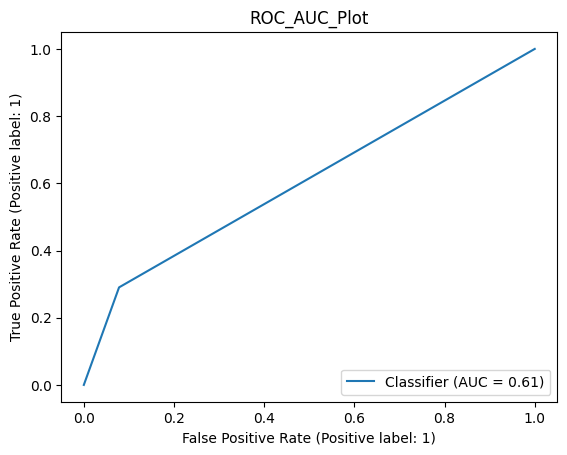

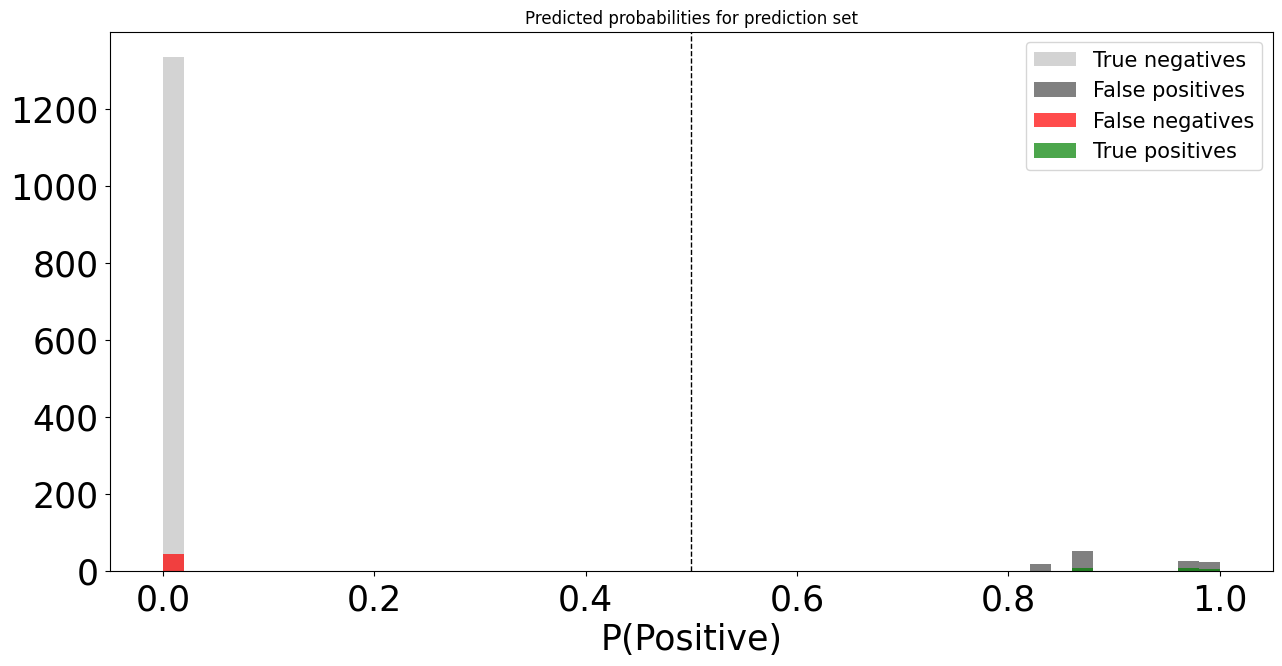

Test P(1) =  4.11%
Test P(1 | predicted 1) =  13.74%
Test P(1 | predicted 0) =  3.20%

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1446
           1       0.14      0.29      0.19        62

    accuracy                           0.90      1508
   macro avg       0.55      0.61      0.57      1508
weighted avg       0.93      0.90      0.91      1508



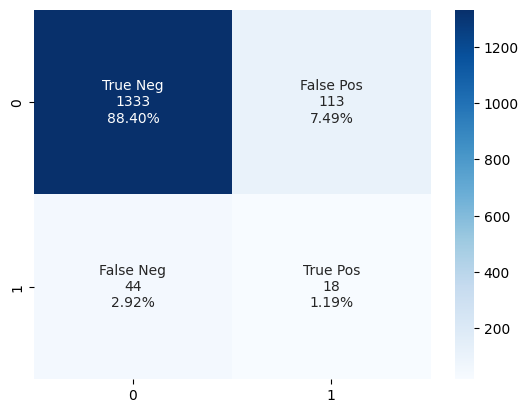

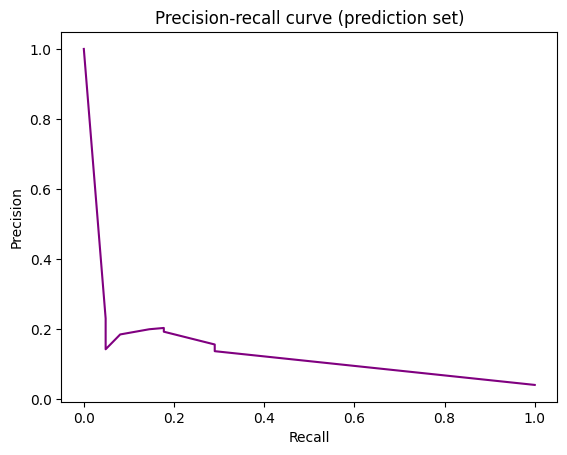

Predictions made: 1508
CPU times: user 16.7 s, sys: 279 ms, total: 17 s
Wall time: 16.8 s


In [28]:
%%time

model_description = "Decision tree"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print()

from sklearn.tree import DecisionTreeClassifier

classifier_dt = DecisionTreeClassifier(random_state=None, class_weight=surveyml.class_weights, max_depth=10, min_samples_leaf=2)
predictions = surveyml.run_prediction_model(classifier_dt)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_dt.feature_importances_)

  Predicting: REJECTED submissions
       Model: Random forest

Running prediction model...

  Training set: (4522, 393) (170 positive)
Prediction set: (1508, 393)

Cross-validating model...

      Train accuracy:  93.48%
     Train precision:  33.51%
           Train F-1:  0.46
 Prediction accuracy:  91.84%
Prediction precision:  23.93%
      Prediction F-1:  0.31
  Test ROC_AUC Score:  0.7

Cross validation results: 

fit_time: 14.408321984608968 (SD: 1.1990409708938121)
score_time: 0.28665410677591957 (SD: 0.0588625517566155)
test_accuracy: 0.9350578562232109 (SD: 0.00740921139606074)
test_precision: 0.26044787587047413 (SD: 0.03684335708834899)
test_f1: 0.31076486644089335 (SD: 0.047167797810887244)
test_roc_auc: 0.8254297633380918 (SD: 0.03395415700465566)


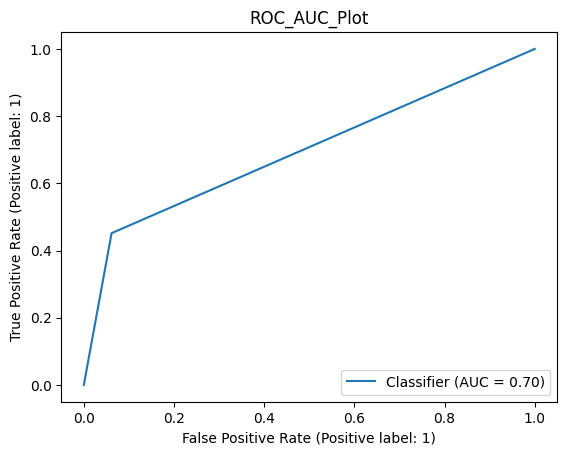

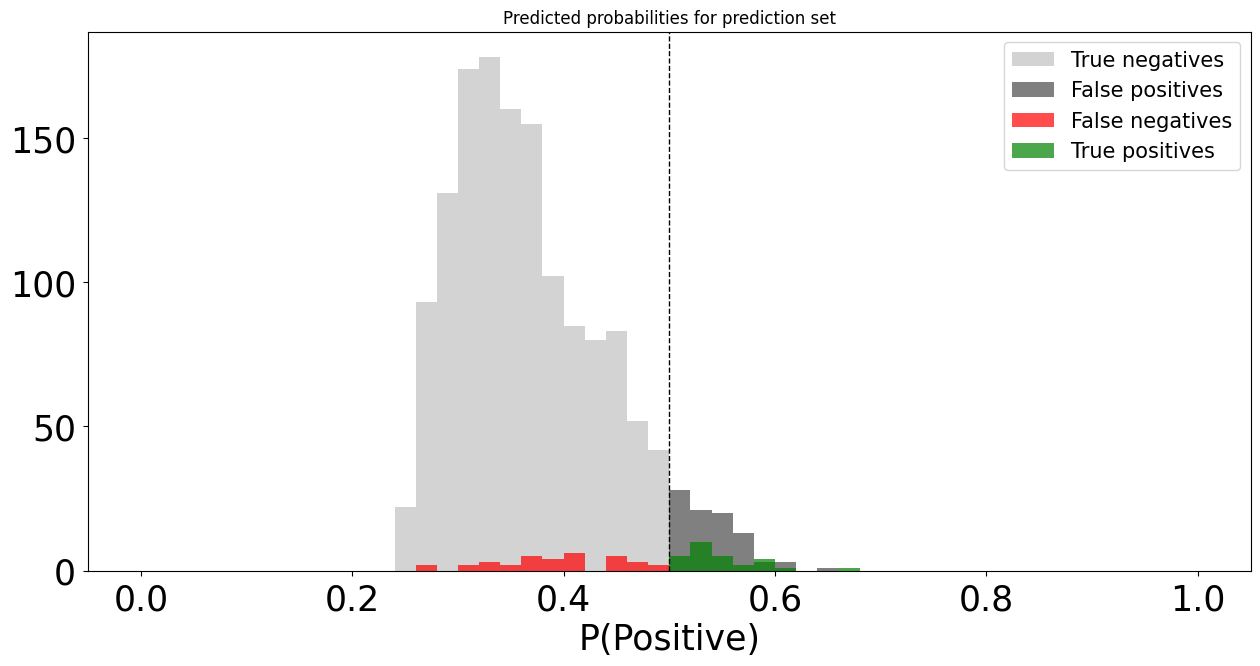

Test P(1) =  4.11%
Test P(1 | predicted 1) =  23.93%
Test P(1 | predicted 0) =  2.44%

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1446
           1       0.24      0.45      0.31        62

    accuracy                           0.92      1508
   macro avg       0.61      0.70      0.63      1508
weighted avg       0.95      0.92      0.93      1508



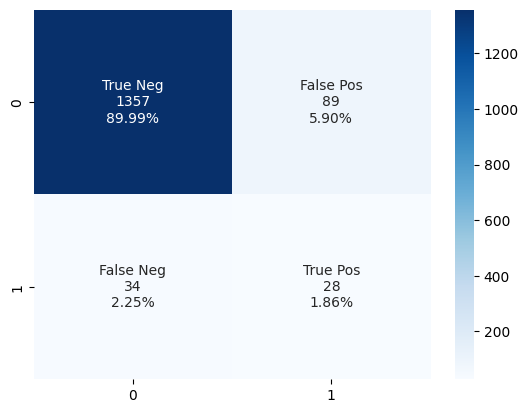

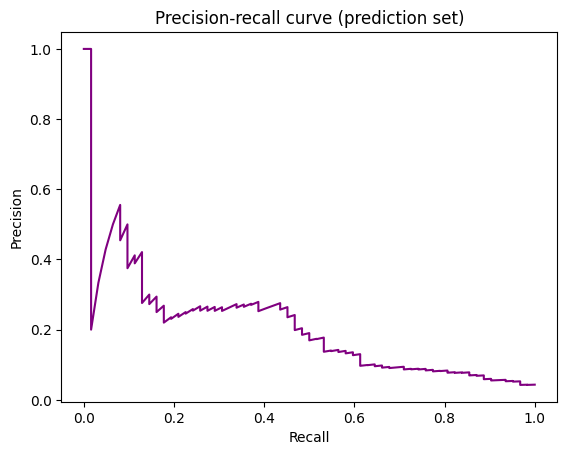

Predictions made: 1508
CPU times: user 3min 57s, sys: 1.26 s, total: 3min 58s
Wall time: 4min


In [29]:
%%time

model_description = "Random forest"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print()

from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=None, n_estimators=1000, class_weight="balanced", max_depth=3, min_samples_leaf=1)
predictions = surveyml.run_prediction_model(classifier_rf)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_rf.feature_importances_)

  Predicting: REJECTED submissions
       Model: XGBoost

Running prediction model...

  Training set: (4522, 393) (170 positive)
Prediction set: (1508, 393)

Cross-validating model...

      Train accuracy:  100.00%
     Train precision:  100.00%
           Train F-1:  1.0
 Prediction accuracy:  95.62%
Prediction precision:  35.71%
      Prediction F-1:  0.13
  Test ROC_AUC Score:  0.54

Cross validation results: 

fit_time: 2.703734048207601 (SD: 0.4947161335111209)
score_time: 0.013648335138956707 (SD: 0.0026434572146471873)
test_accuracy: 0.9624799132971529 (SD: 0.002808089311794333)
test_precision: 0.5098412698412698 (SD: 0.19410342625946586)
test_f1: 0.1797089014010581 (SD: 0.07900843195476723)
test_roc_auc: 0.7855442504541835 (SD: 0.03814683938558382)


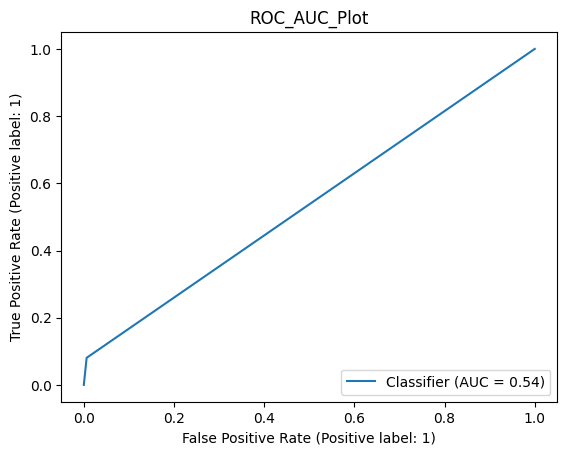

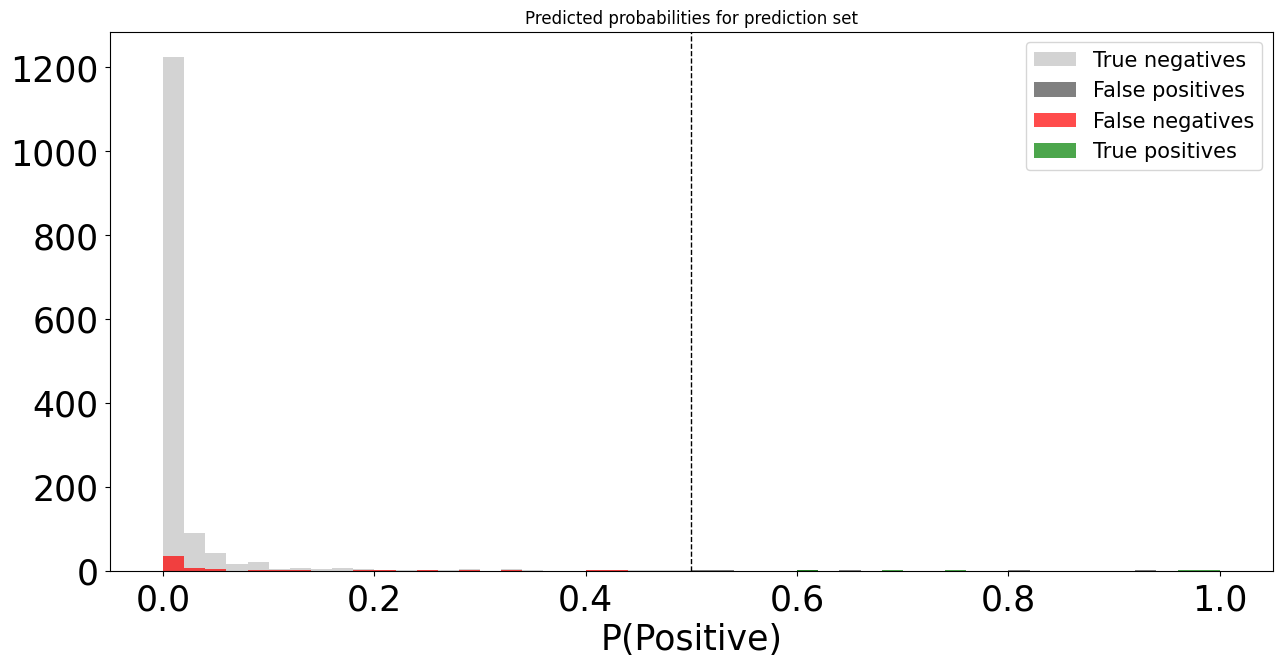

Test P(1) =  4.11%
Test P(1 | predicted 1) =  35.71%
Test P(1 | predicted 0) =  3.82%

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1446
           1       0.36      0.08      0.13        62

    accuracy                           0.96      1508
   macro avg       0.66      0.54      0.55      1508
weighted avg       0.94      0.96      0.94      1508



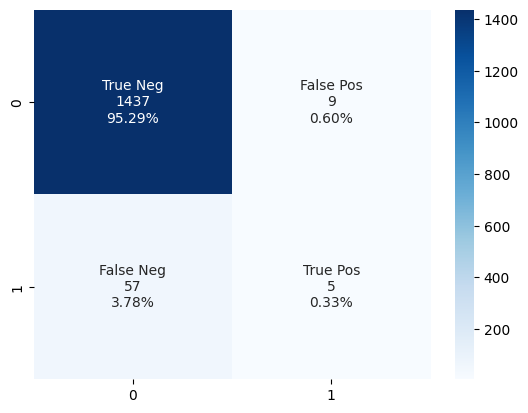

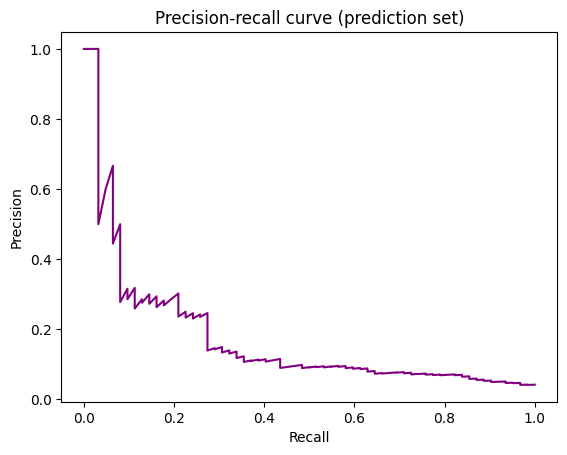

Predictions made: 1508
CPU times: user 7min 33s, sys: 4.41 s, total: 7min 37s
Wall time: 44.6 s


In [30]:
%%time

model_description = "XGBoost"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print()

from xgboost import XGBClassifier

classifier_xb = XGBClassifier(objective='binary:logistic', eval_metric='aucpr', max_depth=3, scale_pos_weight=surveyml.neg_train/surveyml.pos_train)
predictions = surveyml.run_prediction_model(classifier_xb)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_xb.feature_importances_)

  Predicting: REJECTED submissions
       Model: Neural network

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 393)               154842    
                                                                 
 dropout_26 (Dropout)        (None, 393)               0         
                                                                 
 dense_45 (Dense)            (None, 196)               77224     
                                                                 
 dropout_27 (Dropout)        (None, 196)               0         
                                                                 
 dense_46 (Dense)            (None, 1)                 197       
                                                                 
Total params: 232,263
Trainable params: 232,263
Non-trainable params: 0
________________________________________________

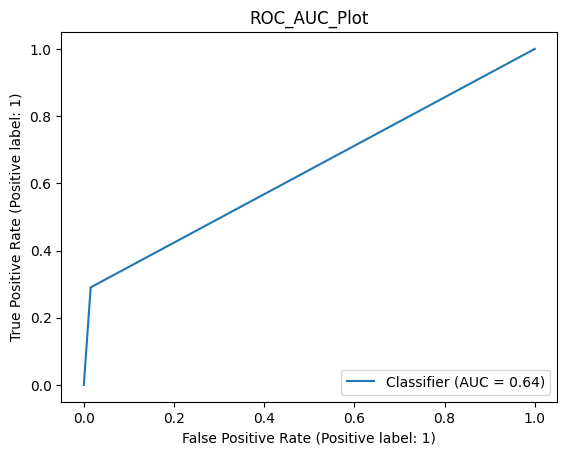

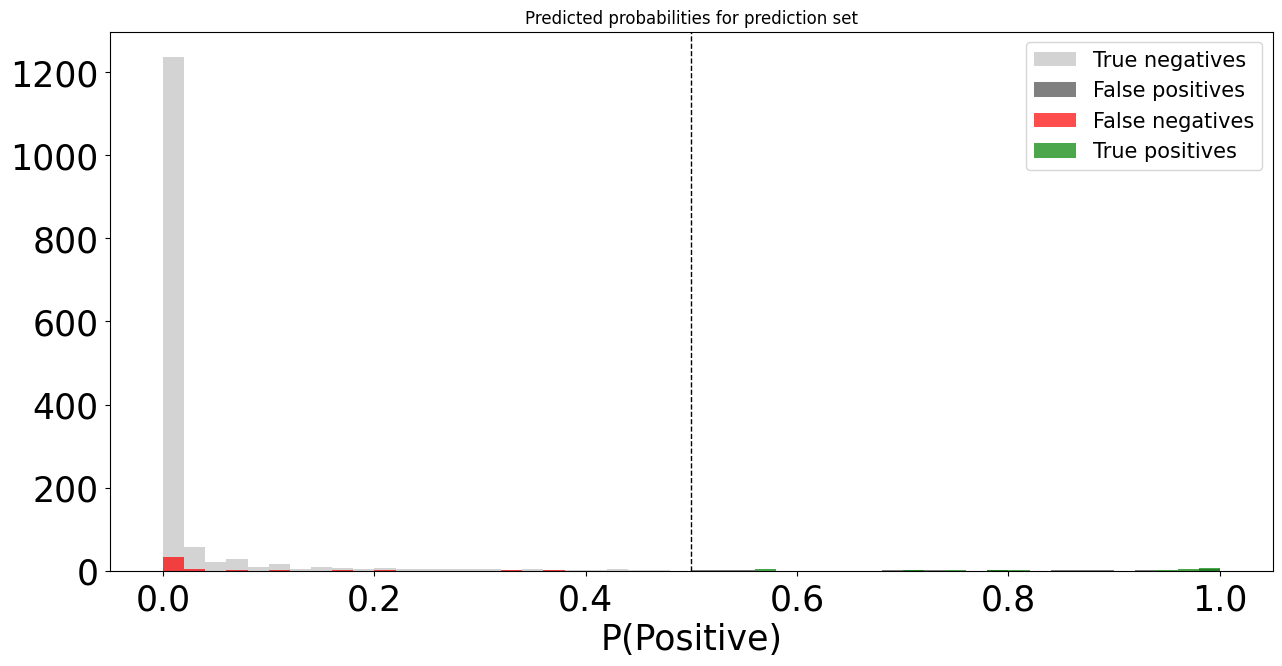

Test P(1) =  4.11%
Test P(1 | predicted 1) =  45.00%
Test P(1 | predicted 0) =  3.00%

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1446
           1       0.45      0.29      0.35        62

    accuracy                           0.96      1508
   macro avg       0.71      0.64      0.67      1508
weighted avg       0.95      0.96      0.95      1508



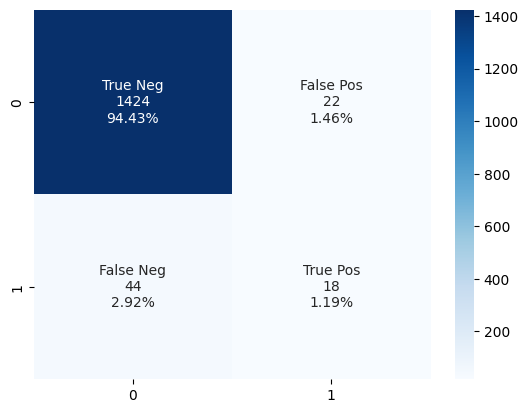

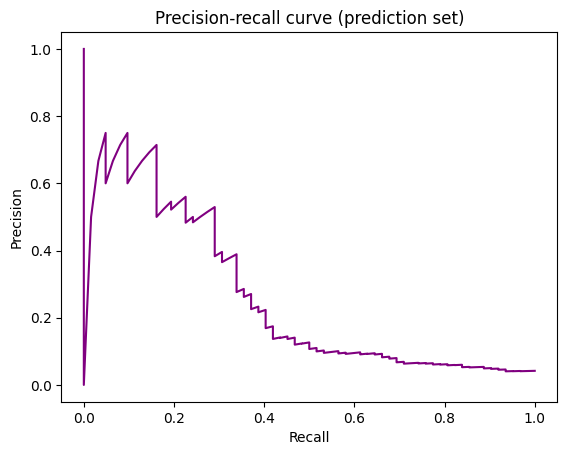

Predictions made: 1508
CPU times: user 59.8 s, sys: 22 s, total: 1min 21s
Wall time: 24.2 s


In [25]:
%%time

model_description = "Neural network"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print()

import numpy as np
import tensorflow as tf
from scikeras.wrappers import KerasClassifier

# set regularization and dropout hyperparameters
l2factor = 0.01
dropoutRate = 0.01
#  use initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
output_bias = tf.keras.initializers.Constant(np.log([surveyml.pos_train/surveyml.neg_train]))
# create neural network model
nnmodel = tf.keras.models.Sequential()
nnmodel.add(tf.keras.layers.Dense(surveyml.num_features, kernel_regularizer=tf.keras.regularizers.l2(l2factor), activation='relu', input_shape=(surveyml.num_features, )))
nnmodel.add(tf.keras.layers.Dropout(dropoutRate))
nnmodel.add(tf.keras.layers.Dense(surveyml.num_features/2, kernel_regularizer=tf.keras.regularizers.l2(l2factor), activation='relu'))
nnmodel.add(tf.keras.layers.Dropout(dropoutRate))
nnmodel.add(tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
# compile model
nnmodel.compile(loss='binary_crossentropy', optimizer='adam',
                metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.AUC(name='roc_auc')])
print(nnmodel.summary())
print()

# create classifier and run model
# classifier_nn = KerasClassifier(nnmodel, epochs=100, batch_size=32, verbose=0, class_weight=surveyml.class_weights)
classifier_nn = KerasClassifier(nnmodel, epochs=40, verbose=0, class_weight=surveyml.class_weights)
predictions = surveyml.run_prediction_model(classifier_nn, supports_cv=False)
print(f"Predictions made: {len(predictions)}")